# Entanglement within the two registers

In [38]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from sympy import *
import random
from random import sample
import math

In [39]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return y
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 

In [40]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix[j][i]=1
             
    for ii in range(N, dim):
        matrix[ii][ii] = 1
             
    matrix = linalg.matrix_power(matrix, 2**power) 
        
    U = UnitaryGate(matrix)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [41]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [93]:
y = 2  
N = 15 

partition = 2
#runs = 3  #mean over the same couple

n = math.ceil(math.log(N,2))
control = QuantumRegister(2*n, 'r1')
target  = QuantumRegister(n, 't1')
classic = ClassicalRegister(2*n, 'c')

couples = []
histogram = []
rho_step =  3 + 1 

for l in range(30):
    somma = np.zeros(rho_step)
    couple = random.sample(range(0, 2*n), partition)
    couples.append(couple)
    #print(couple)

    #for j in range(runs):
    circuit = QuantumCircuit(control, target, classic)
    #couple = random.sample(range(0, 2*n), partition)
    qubits = couple + [8,9,10,11] 
    
    #print(qubits)
    size = len(qubits)
    label = 0
    #circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    #circuit.barrier(3*n - 1)
    circuit.h(range(2*n))
    circuit.x(2*n + n -1)

    #label += 1
    #circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    for q in range(2*n):
        if q == 2*n - 1:
            label = 0
            circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
            circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)])
        else: 
            circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)]) 
    
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])            

    circuit.append(qft_dagger(2*n), range(2*n)) 
    
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    circuit.measure(control, classic)

    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(circuit, aer_sim)
    qobj = assemble(t_qc)                                
    results = aer_sim.run(qobj, shots = 1).result()
    counts = results.get_counts()

    labels = []
    for i in range(len(counts)):
        labels.append(int(list(counts.keys())[i], 2))

    negativities = []
    for i in range(rho_step):
        density_matrix = results.data()['pho_%.1f' % (i)]
        density_matrix_op = density_matrix.to_operator()
        density_matrix_tr = density_matrix_op.transpose()
        negativities.append( linalg.norm(density_matrix_tr) - 1 )
        
    
    #print(negativities)
    #for i in range(len(negativities)):
    #    somma[i] = somma[i] + negativities[i]
    histogram.append(negativities)

    circuit_prova = circuit
    negativities = 0
    counts = 0
    results = 0
    density_matrix = 0
    circuit = 0
    t_qc = 0
    qobj = 0
    #j += 1

    #media = np.zeros(rho_step)
    #for i in range(rho_step):
    #    media[i] =  somma[i]/ 2#*runs

    #histogram.append(media)
    #print(media)
    #media = 0
    #somma = 0


In [43]:
circuit_prova.draw(fold=-1)

┌───┐                                                                                                                                               ┌───────┐         ┌─┐                              
r1_0: ┤ H ├───────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├─────────┤M├──────────────────────────────
      ├───┤       │                                                                                                                                       │       │         └╥┘┌─┐                           
r1_1: ┤ H ├───────┼──────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├──────────╫─┤M├───────────────────────────
      ├───┤       │              │                                                                                                                        │       │          ║ └╥┘┌─┐                        
r1_2: ┤ H ├───────┼──────────────┼──────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────┤2      ├──────────╫──╫─┤M├────────────────────────
      ├───┤       │              │              │                                                                                                         │       │          ║  ║ └╥┘┌─┐                     
r1_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────┤3      ├──────────╫──╫──╫─┤M├─────────────────────
      ├───┤       │              │              │              │                                                                                          │  QFT† │          ║  ║  ║ └╥┘┌─┐                  
r1_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────┤4      ├──────────╫──╫──╫──╫─┤M├──────────────────
      ├───┤       │              │              │              │              │                                            ░                         ░    │       │    ░     ║  ║  ║  ║ └╥┘   ┌─┐       ░    
r1_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■────────────────────────────░─────────────────────────░────┤5      ├────░─────╫──╫──╫──╫──╫────┤M├───────░────
      ├───┤       │              │              │              │              │               │                         pho_0.0                   pho_1.0 │       │ pho_2.0  ║  ║  ║  ║  ║    └╥┘┌─┐ pho_3.0 
r1_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■────────────░─────────────────────────░────┤6      ├────░─────╫──╫──╫──╫──╫─────╫─┤M├────░────
      ├───┤       │              │              │              │              │               │               │            ░                         ░    │       │    ░     ║  ║  ║  ║  ║ ┌─┐ ║ └╥┘    ░    
r1_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼─────────────────────────■─────────────────┤7      ├──────────╫──╫──╫──╫──╫─┤M├─╫──╫──────────
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐    ░    ┌───────┴───────┐    ░    └───────┘    ░     ║  ║  ║  ║  ║ └╥┘ ║  ║     ░    
t1_0: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├────░────┤0              ├────░─────────────────░─────╫──╫──╫──╫──╫──╫──╫──╫─────░────
           │             ││             ││             ││             ││              ││              ││              │    ░    │               │    ░                 ░     ║  ║  ║  ║  ║  ║  ║  ║     ░    
t1_1: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1   

# For histogram

In [120]:
#creating the histogram
bins = []

for i in range(2*n):
    for j in range(2*n):
        if i != j:
            bins.append([i,j])

dataBEF = np.zeros(len(bins))
dataAFT = np.zeros(len(bins))

for i in range(len(couples)):
    for ii in range(len(bins) ):
        if couples[i] == bins[ii]:
            #print(couples[i])
            dataBEF[ii] = dataBEF[ii] + histogram[i][1]
            dataAFT[ii] = dataAFT[ii] +  histogram[i][2]
            


In [94]:
#voglio vedere before and after in queste coppie 
bins[0],bins[48]

([0, 1], [6, 7])

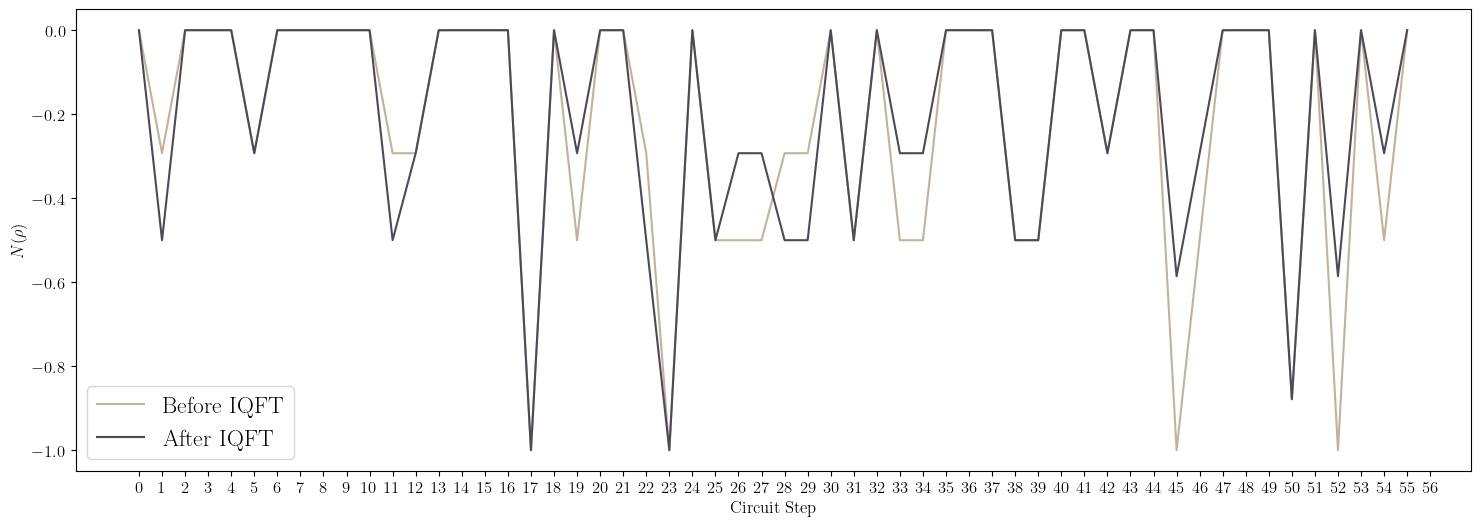

In [141]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 6))
params = {'text.usetex' : True, 'font.size' : 12, 'font.family' : 'serif'}
plt.rcParams.update(params)

xs = []
for i in range(0, 57, 1):
    if i == 0 or i == 48:
        xs.append(i)
    else:
        xs.append(i)

plt.xticks(xs, fontsize = 12)
plt.xlabel('Circuit Step')
plt.ylabel(r"$N(\rho)$")
plt.plot(dataBEF,color = '#C3B299', label = 'Before IQFT')
plt.plot(dataAFT, color = '#4C495A', label = 'After IQFT')
plt.legend(fontsize=17)

plt.savefig('shor_traslationBIS.pdf', format = 'pdf')


In [124]:
bins[0],bins[48]

([0, 1], [6, 7])

# For a single couple

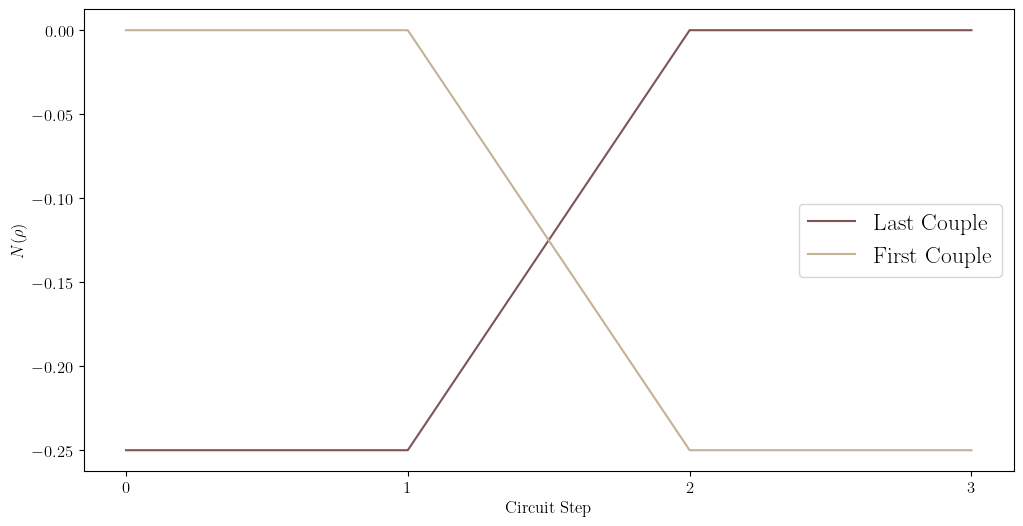

In [117]:
media01 = [ 1.11022302e-16,  2.22044605e-16,  7.91589017e-14,  1.61537450e-13,
        1.61537450e-13,  1.61537450e-13,  1.61537450e-13,  1.61537450e-13,
        1.61537450e-13,  1.61537450e-13, -2.50000000e-01, -2.50000000e-01]

media67 = [ 1.11022302e-16,  2.22044605e-16, -1.46446609e-01, -2.50000000e-01,
       -2.50000000e-01, -2.50000000e-01, -2.50000000e-01, -2.50000000e-01,
       -2.50000000e-01, -2.50000000e-01,  1.61870517e-13, -1.11022302e-16]
xs = []
for i in range(0, 5, 1):
    xs.append(i)

media01_cut = [1.61537450e-13,  1.61537450e-13, -2.50000000e-01, -2.50000000e-01]
media67_cut = [-2.50000000e-01, -2.50000000e-01,  1.61870517e-13, -1.11022302e-16]
plt.xlabel('Circuit Step')
plt.ylabel(r"$N(\rho)$")
plt.xticks(xs)
plt.plot(media67_cut, label = 'Last Couple', color = '#815355')
plt.plot(media01_cut, label = 'First Couple', color = '#C3B299')
plt.legend(fontsize=17)
plt.savefig('shor_traslation.pdf', format = 'pdf')

In [ ]:
np.finfo(np.float64).eps